### Block 1 - Setup and imports

In [13]:
import re
import time
from datetime import datetime
from typing import Optional, Tuple
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

### Block 2 - Selenium scrape the index page and build the link table

In [12]:
# INSTANTIATE DRIVER -> REPLACE WITH YOUR BROWSER IF NEEDED
driver = webdriver.Chrome()

# GO DIRECTLY TO THE MONETARY POLICY STATEMENT INDEX PAGE (EN)
driver.get("https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/html/index.en.html")

# SCROLL TO LOAD ALL CONTENT (kept close to your original logic)
for x in range(0, 10000, 200):
    driver.execute_script("window.scrollBy(0, " + str(x) + ");")
    time.sleep(0.5)

# GET WEBPAGE SOURCE
html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

# COLLECT ALL LINKS
r = []
for a in soup.find_all("a", href=True):
    r.append(a["href"])

# REMOVE DUPLICATES
r = list(set(r))

# CONSTRUCT DATAFRAME
df = pd.DataFrame(r, columns=["link"]).sort_values("link")

# KEEP ONLY MONETARY POLICY STATEMENT DOCUMENTS (EN HTML), EXCLUDING THE INDEX ITSELF
df = df.loc[
    (df["link"].str.contains("press_conference/monetary-policy-statement", na=False)) &
    (df["link"].str.contains(r"\.en\.html$", na=False)) &
    (~df["link"].str.contains("index.en.html", na=False))
].reset_index(drop=True)

print(f"TOTAL DOCUMENTS : {len(df)}")
df.head()

TOTAL DOCUMENTS : 292


,link
0,/press/press_conference/monetary-policy-statem...
1,/press/press_conference/monetary-policy-statem...
2,/press/press_conference/monetary-policy-statem...
3,/press/press_conference/monetary-policy-statem...
4,/press/press_conference/monetary-policy-statem...


### Block 3 - Download each statement page and extract `content`, `title` and `date`

In [14]:
content = []
date = []
title = []

HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; AcademicReplication/1.0)"}

print(f"TOTAL DOCUMENTS : {len(df)}")

for i, x in tqdm(df.iterrows(), total=df.shape[0]):

    url = "https://www.ecb.europa.eu" + x["link"]

    try:
        req = requests.get(url, headers=HEADERS, timeout=30)
        req.raise_for_status()
        soup = BeautifulSoup(req.content, "html.parser")

        c = []
        sections = soup.find_all("div", {"class": "section"})
        for section in sections:
            for text_container in section.find_all(["h2", "p"]):
                txt = text_container.get_text(strip=True)
                if txt:
                    c.append(txt)

        # Fallback if the page structure differs and we captured nothing
        if len(c) == 0:
            main = soup.find("main") or soup.find("article")
            fallback_text = main.get_text(" ", strip=True) if main else soup.get_text(" ", strip=True)
            c = [fallback_text] if fallback_text else []

        content.append("\n".join(c))

        h1_tag = soup.find("h1")
        if h1_tag:
            h1_text = h1_tag.get_text(strip=True)
            h1_low = h1_text.lower()

            # Keep your original intent, but with correct logic
            if (
                ("introductory statement" in h1_low) or
                ("monetary policy statement" in h1_low) or
                ("press conference" in h1_low)
            ):
                title.append(h1_text)
            else:
                title.append(None)
        else:
            title.append(None)

        meta_date = soup.find("meta", {"property": "article:published_time"})
        if meta_date and meta_date.get("content"):
            date.append(meta_date["content"].strip())
        else:
            time_tag = soup.find("time")
            if time_tag and time_tag.get("datetime"):
                date.append(time_tag["datetime"].strip())
            else:
                date.append(None)

    except Exception as e:
        print(f"Error on URL {url}: {e}")
        content.append("")
        title.append(None)
        date.append(None)

df["content"] = content
df["date"] = date
df["title"] = title

# Drop rows that failed title/date extraction
df = df.dropna(subset=["title", "date"]).reset_index(drop=True)

print(f"DOCUMENTS AFTER FILTERING : {len(df)}")
df.head()

TOTAL DOCUMENTS : 292


 94%|█████████▍| 275/292 [07:27<04:05, 14.46s/it]

Error on URL https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is231026~c23b4eb5f0.en.html: HTTPSConnectionPool(host='www.ecb.europa.eu', port=443): Read timed out.


100%|██████████| 292/292 [08:14<00:00,  1.69s/it]

DOCUMENTS AFTER FILTERING : 288


,link,content,date,title
0,/press/press_conference/monetary-policy-statem...,"Willem F. Duisenberg, President of the Europea...",1998-06-09,ECB Press conference: Introductory statement
1,/press/press_conference/monetary-policy-statem...,"Willem F. Duisenberg, President of the Europea...",1998-07-08,ECB Press conference: Introductory statement
2,/press/press_conference/monetary-policy-statem...,"Willem F. Duisenberg, President of the Europea...",1998-09-11,ECB Press conference: Introductory statement
3,/press/press_conference/monetary-policy-statem...,"Willem F. Duisenberg, President of the Europea...",1998-10-13,ECB Press conference: Introductory statement
4,/press/press_conference/monetary-policy-statem...,"Willem F. Duisenberg, President of the Europea...",1998-11-03,ECB Press conference: Introductory statement


### Block 4 - Convert dates, create year, remove unwanted rows, and validate counts

In [15]:
# 1) Convert date and extract year
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).copy()
df["year"] = df["date"].dt.year

# 2) Exclude 1998
df = df[df["year"] != 1998].copy()

# 3) Exclude known unwanted links
intruder_links = [
    "/press/press_conference/monetary-policy-statement/2000/html/is000330.en.html",
    "/press/press_conference/monetary-policy-statement/2000/html/is001019.en.html",
    "/press/press_conference/monetary-policy-statement/2001/html/is011213.en.html",
    "/press/press_conference/monetary-policy-statement/2002/html/is020103_2.en.html",
    "/press/press_conference/monetary-policy-statement/2003/html/is030917.en.html",
    "/press/press_conference/monetary-policy-statement/2003/html/is031013.en.html",
    "/press/press_conference/monetary-policy-statement/2005/html/is050120.en.html",
    "/press/press_conference/monetary-policy-statement/2005/html/is050120_1.en.html",
    "/press/press_conference/monetary-policy-statement/2014/html/is141026.en.html",
    "/press/press_conference/monetary-policy-statement/2021/html/ecb.sp210708~ab68c3bd9d.en.html",
    "/press/press_conference/monetary-policy-statement/html/index.en.html",
]

df = df[~df["link"].isin(intruder_links)].copy()

# 4) Sort and verify the result
df = df.sort_values("date").reset_index(drop=True)

counts_by_year = df["year"].value_counts().sort_index()
print("Number of documents by year:")
print(counts_by_year)
print(f"\nTotal documents: {len(df)}")

df[["date", "year", "title", "link"]].head(10)

Number of documents by year:
year
1999    11
2000    11
2001    11
2002    11
2003    11
2004    11
2005    11
2006    12
2007    11
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015     8
2016     8
2017     8
2018     8
2019     8
2020     8
2021     8
2022     8
2023     7
2024     8
2025     8
Name: count, dtype: int64

Total documents: 271


,date,year,title,link
0,1999-01-07,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
1,1999-02-04,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
2,1999-03-04,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
3,1999-04-08,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
4,1999-05-06,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
5,1999-06-02,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
6,1999-07-15,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
7,1999-09-09,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
8,1999-10-07,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...
9,1999-11-04,1999,ECB Press conference: Introductory statement,/press/press_conference/monetary-policy-statem...


In [18]:
# Ensure we still only have statement pages
assert df["link"].str.contains("monetary-policy-statement", na=False).all()

# Check monotonic ordering after sort
assert df["date"].is_monotonic_increasing

### Block 5 - Text cleaning / preprocessing

In [19]:
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stops = set(stopwords.words("english"))
porter = PorterStemmer()

def clean_text(text):
    # Handle missing / non-string values
    if not isinstance(text, str):
        return np.nan

    text = text.lower()

    # Cut off Q&A / transcript parts (keep only the statement)
    markers = [
        "we are now at your disposal",
        "we stand ready to answer any questions you may have",
        "transcript of the questions asked and the answers",
        "questions and answers",
        "question",
        "questions",
    ]

    for m in markers:
        if m in text:
            text = text.split(m)[0]
            break

    # Keep only letters, apostrophes, spaces, and hyphens
    text = re.sub(r"[^a-z'\s-]", " ", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords + very short tokens (optional but helpful)
    tokens = [t for t in tokens if t not in stops and len(t) > 1]

    # Stem
    tokens = [porter.stem(t) for t in tokens]

    return " ".join(tokens)

df["clean_text"] = df["content"].apply(clean_text)

# Quick checks
print("Missing clean_text:", df["clean_text"].isna().sum())
print("Example cleaned text:\n", df["clean_text"].iloc[0][:400])

Missing clean_text: 0
Example cleaned text:
 willem duisenberg presid european central bank thursday januari transcript question answer ladi gentlemen vice-presid today report outcom first meet govern council european central bank stage three econom monetari union first time govern council took decis oper natur context singl monetari polici januari euro success launch day onward eurosystem ecb eleven nation central bank member state particip


### Block 6 - Similarity (Jaccard on binary bigrams), i vs i−1

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# 0) Ensure chronological order (critical for i vs i-1)
df = df.sort_values("date").reset_index(drop=True)

# 1) Vectorize: binary bigram presence
cv = CountVectorizer(
    ngram_range=(2, 2),
    stop_words=None,
    binary=True
)

# If some clean_text are missing, treat them as empty strings (keeps row alignment)
X = cv.fit_transform(df["clean_text"].fillna(""))

# 2) Jaccard similarity vs previous document
similarity = [0.0]  # first document has no previous reference

for i in range(1, X.shape[0]):
    vec_prev = X[i - 1]
    vec_curr = X[i]

    # Intersection: count of bigrams present in both
    intersection = (vec_prev.multiply(vec_curr)).sum()

    # Union: |A| + |B| - |A ∩ B|
    n_prev = vec_prev.sum()
    n_curr = vec_curr.sum()
    union = n_prev + n_curr - intersection

    sim = float(intersection / union) if union > 0 else 0.0
    similarity.append(sim)

df["similarity_sklearn"] = similarity

# 3) Basic stats (sanity check)
similarity_stats = {
    "Mean": df["similarity_sklearn"].mean(),
    "Std": df["similarity_sklearn"].std(),
    "Min": df["similarity_sklearn"].min(),
    "25%": df["similarity_sklearn"].quantile(0.25),
    "Median": df["similarity_sklearn"].median(),
    "75%": df["similarity_sklearn"].quantile(0.75),
    "Max": df["similarity_sklearn"].max(),
}

print("\n=== SIMILARITY (JACCARD, BINARY BIGRAMS) ===")
for k, v in similarity_stats.items():
    print(f"{k + ':':<10} {v:>10.4f}")


=== SIMILARITY (JACCARD, BINARY BIGRAMS) ===
Mean:          0.2927
Std:           0.1472
Min:           0.0000
25%:           0.1646
Median:        0.2982
75%:           0.4004
Max:           0.7333


In [21]:
bigrams_per_doc = np.asarray(X.sum(axis=1)).ravel()
print("Docs with 0 bigrams:", int((bigrams_per_doc == 0).sum()))

Docs with 0 bigrams: 0


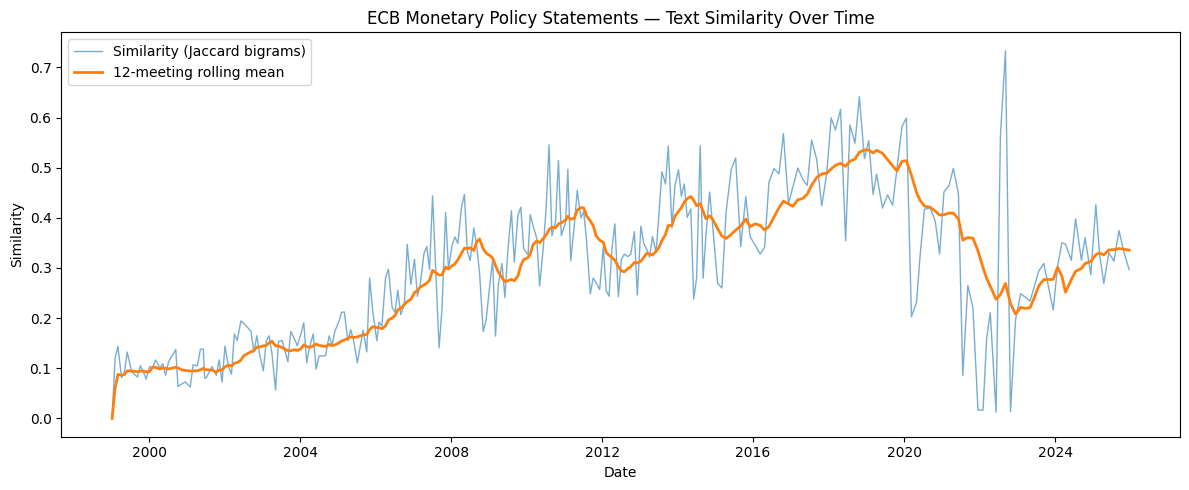

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").reset_index(drop=True)

# rolling mean to see the trend
df["similarity_ma_12"] = df["similarity_sklearn"].rolling(window=12, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["similarity_sklearn"], linewidth=1, alpha=0.6, label="Similarity (Jaccard bigrams)")
plt.plot(df["date"], df["similarity_ma_12"], linewidth=2, label="12-meeting rolling mean")
plt.title("ECB Monetary Policy Statements - Text Similarity Over Time")
plt.xlabel("Date")
plt.ylabel("Similarity")
plt.legend()
plt.tight_layout()
plt.show()

### Block 7 - Pessimism (Loughran–McDonald dictionary)

In [24]:
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer

porter = PorterStemmer()

# 1) Load LM dictionary (ADJUST PATH)
lm_path = "/Users/eduardo/Downloads/Loughran-McDonald_MasterDictionary_1993-2024.csv"
lm = pd.read_csv(lm_path)

# 2) Build word lists
neg_words = lm.loc[lm["Negative"] > 0, "Word"].astype(str).str.lower().tolist()
pos_words = lm.loc[lm["Positive"] > 0, "Word"].astype(str).str.lower().tolist()

# 3) Stem words to match df['clean_text'] (which is stemmed)
neg_words_stemmed = set(porter.stem(w) for w in neg_words)
pos_words_stemmed = set(porter.stem(w) for w in pos_words)

# 4) Document-level pessimism
def compute_pessimism(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.nan

    tokens = text.split()
    total = len(tokens)
    if total == 0:
        return np.nan

    n_neg = sum(1 for t in tokens if t in neg_words_stemmed)
    n_pos = sum(1 for t in tokens if t in pos_words_stemmed)

    return ((n_neg - n_pos) / total) * 100

df["pessimism_raw"] = df["clean_text"].apply(compute_pessimism)

# 5) Basic stats (sanity check)
pessimism_stats = {
    "Mean": df["pessimism_raw"].mean(),
    "Std": df["pessimism_raw"].std(),
    "Min": df["pessimism_raw"].min(),
    "25%": df["pessimism_raw"].quantile(0.25),
    "Median": df["pessimism_raw"].median(),
    "75%": df["pessimism_raw"].quantile(0.75),
    "Max": df["pessimism_raw"].max(),
}

print("\n=== PESSIMISM (LM, RAW) ===")
for k, v in pessimism_stats.items():
    print(f"{k + ':':<10} {v:>10.4f}")


=== PESSIMISM (LM, RAW) ===
Mean:          0.3609
Std:           1.5497
Min:          -3.9627
25%:          -0.6030
Median:        0.3916
75%:           1.3233
Max:           4.2391


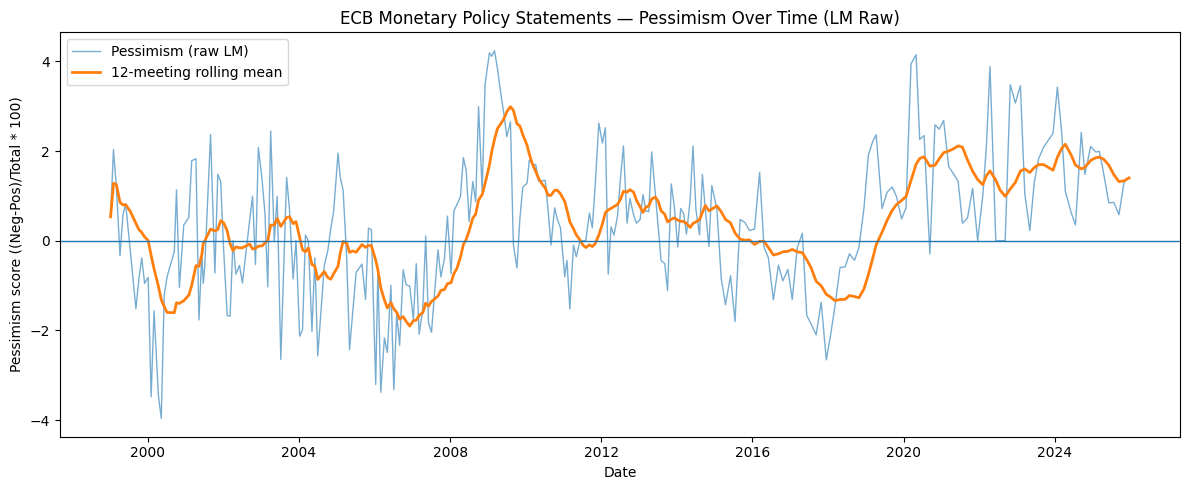

In [26]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").reset_index(drop=True)

# Rolling mean (optional trend)
df["pessimism_ma_12"] = df["pessimism_raw"].rolling(window=12, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["pessimism_raw"], linewidth=1, alpha=0.6, label="Pessimism (raw LM)")
plt.plot(df["date"], df["pessimism_ma_12"], linewidth=2, label="12-meeting rolling mean")
plt.axhline(0, linewidth=1)
plt.title("ECB Monetary Policy Statements — Pessimism Over Time (LM Raw)")
plt.xlabel("Date")
plt.ylabel("Pessimism score ((Neg-Pos)/Total * 100)")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
print("Share of non-missing pessimism:", df["pessimism_raw"].notna().mean())
print("Share of exactly zero:", (df["pessimism_raw"] == 0).mean())
df[["date", "pessimism_raw", "title"]].head()

Share of non-missing pessimism: 1.0
Share of exactly zero: 0.04059040590405904


,date,pessimism_raw,title
0,1999-01-07,0.533049,ECB Press conference: Introductory statement
1,1999-02-04,2.029770,ECB Press conference: Introductory statement
2,1999-03-04,1.199041,ECB Press conference: Introductory statement
3,1999-04-08,-0.331675,ECB Press conference: Introductory statement
4,1999-05-06,0.566038,ECB Press conference: Introductory statement
5,1999-06-02,0.825083,ECB Press conference: Introductory statement
6,1999-07-15,-0.196464,ECB Press conference: Introductory statement
7,1999-09-09,-1.516588,ECB Press conference: Introductory statement
8,1999-10-07,-0.865266,ECB Press conference: Introductory statement
9,1999-11-04,-0.384123,ECB Press conference: Introductory statement


### Block 8 - Clean LM dictionary for ECB context (“kill lists”) + final pessimism

We propose to remove systematic false positives/negatives that are common in ECB statements (e.g., “press”, “question”, “liquidity”, “easing”, etc.), then recompute the pessimism score as pessimism_final

In [27]:
kill_list_neg = [
    # Q&A / structure / politeness
    "question", "questions", "vice", "general", "press", "lie",

    # ECB technical terms that are neutral in context
    "risk", "risks",
    "deficit", "deficits",
    "liquid", "liquidity",
    "object", "objective",
    "dispos", "disposable",
    "lag", "lagged",
    "eas", "easing",
    "implic", "implication",
    "restructur", "restructuring",
    "prevent",

    # Often “good news” in ECB context (e.g., inflation declining)
    "decline", "declined", "declining",
    "dampen", "dampened",
    "limit", "limited",

    # Neutral intensifiers commonly used
    "crucial", "persistent", "challeng", "challenges", "urgent",
]

kill_list_pos = [
    # Politeness / boilerplate
    "pleas", "pleased", "pleasure", "happy", "kind", "welcome", "good",

    # Neutral ECB usage
    "inform", "information",
    "opportun", "opportunity",
    "conclus", "conclusion",
    "share",
    "lead", "leading",
]

# IMPORTANT: your corpus is stemmed, so keep kill lists stemmed too.
# If you want to be 100% safe, stem them again (idempotent for most stems):
kill_list_neg = set(porter.stem(w) for w in kill_list_neg)
kill_list_pos = set(porter.stem(w) for w in kill_list_pos)


In [28]:
# Start from the stemmed sets built in Block 7
neg_words_clean = set(neg_words_stemmed) - kill_list_neg
pos_words_clean = set(pos_words_stemmed) - kill_list_pos

print(f"Negatives kept: {len(neg_words_clean)} (removed {len(neg_words_stemmed) - len(neg_words_clean)})")
print(f"Positives kept: {len(pos_words_clean)} (removed {len(pos_words_stemmed) - len(pos_words_clean)})")

Negatives kept: 892 (removed 19)
Positives kept: 141 (removed 8)


In [29]:
import numpy as np

def compute_pessimism_final(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.nan

    tokens = text.split()
    total = len(tokens)
    if total == 0:
        return np.nan

    n_neg = sum(1 for t in tokens if t in neg_words_clean)
    n_pos = sum(1 for t in tokens if t in pos_words_clean)

    return ((n_neg - n_pos) / total) * 100

df["pessimism_final"] = df["clean_text"].apply(compute_pessimism_final)

# Stats
pessimism_final_stats = {
    "Mean": df["pessimism_final"].mean(),
    "Std": df["pessimism_final"].std(),
    "Min": df["pessimism_final"].min(),
    "25%": df["pessimism_final"].quantile(0.25),
    "Median": df["pessimism_final"].median(),
    "75%": df["pessimism_final"].quantile(0.75),
    "Max": df["pessimism_final"].max(),
}

print("\n=== PESSIMISM (CLEANED, FINAL) ===")
for k, v in pessimism_final_stats.items():
    print(f"{k + ':':<10} {v:>10.4f}")


=== PESSIMISM (CLEANED, FINAL) ===
Mean:         -0.4312
Std:           1.4386
Min:          -4.6620
25%:          -1.3375
Median:       -0.3484
75%:           0.4829
Max:           3.3333


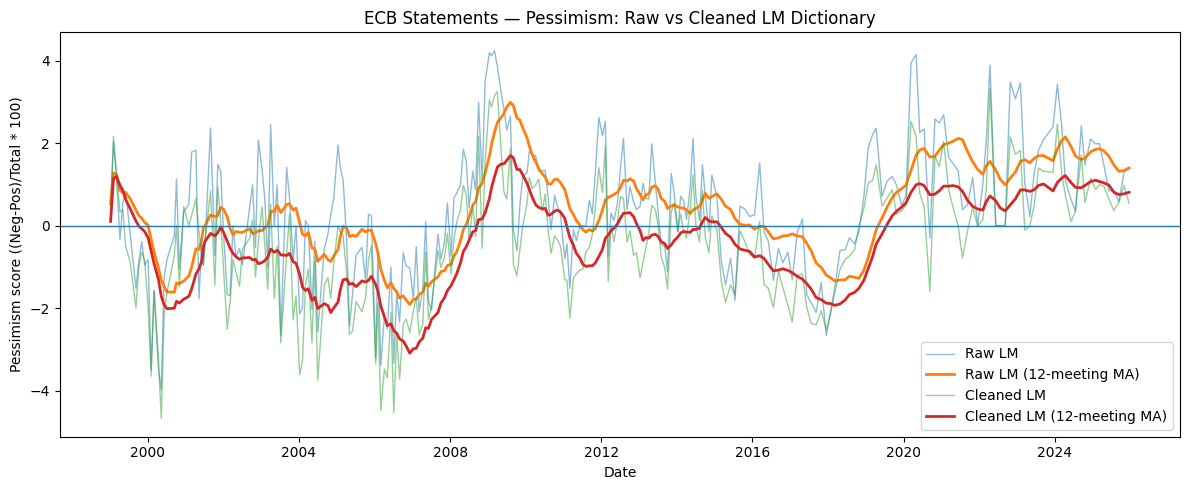

In [32]:
# Rolling means (optional, but useful for readability)
df["pess_raw_ma_12"] = df["pessimism_raw"].rolling(window=12, min_periods=1).mean()
df["pess_final_ma_12"] = df["pessimism_final"].rolling(window=12, min_periods=1).mean()

plt.figure(figsize=(12, 5))

# Raw
plt.plot(df["date"], df["pessimism_raw"], linewidth=1, alpha=0.5, label="Raw LM")
plt.plot(df["date"], df["pess_raw_ma_12"], linewidth=2, label="Raw LM (12-meeting MA)")

# Final
plt.plot(df["date"], df["pessimism_final"], linewidth=1, alpha=0.5, label="Cleaned LM")
plt.plot(df["date"], df["pess_final_ma_12"], linewidth=2, label="Cleaned LM (12-meeting MA)")

plt.axhline(0, linewidth=1)
plt.title("ECB Statements — Pessimism: Raw vs Cleaned LM Dictionary")
plt.xlabel("Date")
plt.ylabel("Pessimism score ((Neg-Pos)/Total * 100)")
plt.legend()
plt.tight_layout()
plt.show()

### Block 10 - STOXX 50 (Euro Stoxx 50) prices + log returns

build a clean daily price/return series that we will later use to compute abnormal returns and CAR / |CAR| around each ECB statement date.

In [47]:
import yfinance as yf

START_DATE = "1999-01-01"
END_DATE   = "2025-12-31"

# Explicitly set auto_adjust to avoid version-dependent defaults/warnings
stoxx = yf.download(
    "^STOXX50E",
    start=START_DATE,
    end=END_DATE,
    auto_adjust=False,
    progress=False
)

# Ensure datetime index
stoxx.index = pd.to_datetime(stoxx.index)

print("Date range:", stoxx.index.min().date(), "->", stoxx.index.max().date())
print(stoxx.head())

Date range: 2007-03-30 -> 2025-12-29
Price         Adj Close        Close         High          Low         Open  \
Ticker        ^STOXX50E    ^STOXX50E    ^STOXX50E    ^STOXX50E    ^STOXX50E   
Date                                                                          
2007-03-30  4181.029785  4181.029785  4207.759766  4160.350098  4177.669922   
2007-04-02  4189.549805  4189.549805  4191.759766  4163.770020  4177.310059   
2007-04-03  4246.299805  4246.299805  4248.069824  4199.540039  4199.540039   
2007-04-04  4261.830078  4261.830078  4261.830078  4242.049805  4252.709961   
2007-04-05  4271.540039  4271.540039  4274.169922  4253.790039  4259.979980   

Price         Volume  
Ticker     ^STOXX50E  
Date                  
2007-03-30         0  
2007-04-02         0  
2007-04-03         0  
2007-04-04         0  
2007-04-05         0  


In [48]:
import numpy as np
import pandas as pd


if isinstance(stoxx.columns, pd.MultiIndex):
    stoxx = stoxx.xs(stoxx.columns.levels[1][0], axis=1, level=1)

price_col = "Adj Close" if "Adj Close" in stoxx.columns else "Close"

stoxx[price_col] = pd.to_numeric(stoxx[price_col], errors="coerce")

stoxx["Log_Return"] = np.log(stoxx[price_col] / stoxx[price_col].shift(1))

stoxx = stoxx.dropna(subset=["Log_Return"])

print("Remaining rows:", len(stoxx))
print("NaNs in Volume:", stoxx["Volume"].isna().sum() if "Volume" in stoxx.columns else "no Volume column")

stoxx["Log_Return"].describe()

Remaining rows: 4699
NaNs in Volume: 0


count    4699.000000
mean        0.000068
std         0.013822
min        -0.132405
25%        -0.006116
50%         0.000446
75%         0.006735
max         0.104376
Name: Log_Return, dtype: float64

### Block 11 — Compute CAR and |CAR| for each ECB statement date

We compute an event-study CAR using:

- Estimation window:−250,−50 trading days before the event

- Event window: −5,+5 trading days around the event

- Expected return = mean log return in estimation window (simple “constant mean return” model)

- CAR = sum of abnormal returns in the event window

- ABS_CAR = abs(CAR) * 100 (percent)

In [49]:
import numpy as np
import pandas as pd

def compute_car_constant_mean(event_date, returns_series, est_len=250, gap=50, evt_window=5):
    """
    Constant-mean event study:
    - Estimation window: [-est_len, -gap] trading days relative to event index
    - Event window:      [-evt_window, +evt_window]
    returns_series: pd.Series of daily log returns indexed by DatetimeIndex
    """
    event_date = pd.to_datetime(event_date)

    # Find the nearest trading day (handles weekends/holidays)
    idx_pos = returns_series.index.get_indexer([event_date], method="nearest")[0]

    est_start = idx_pos - est_len
    est_end   = idx_pos - gap          # exclusive in iloc slicing below
    evt_start = idx_pos - evt_window
    evt_end   = idx_pos + evt_window

    # Bounds check
    if est_start < 0 or evt_end >= len(returns_series):
        return np.nan

    est_returns = returns_series.iloc[est_start:est_end]
    expected = est_returns.mean()

    evt_returns = returns_series.iloc[evt_start:evt_end + 1]
    abnormal = evt_returns - expected

    car = abnormal.sum()
    return float(car)

In [50]:
# Ensure dates are clean/sorted
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# Use the returns series from Block 10
ret = stoxx["Log_Return"].dropna()

df["CAR"] = df["date"].apply(lambda d: compute_car_constant_mean(d, ret))
df["ABS_CAR"] = df["CAR"].abs() * 100

print(df[["date", "CAR", "ABS_CAR"]].head())

        date  CAR  ABS_CAR
0 1999-01-07  NaN      NaN
1 1999-02-04  NaN      NaN
2 1999-03-04  NaN      NaN
3 1999-04-08  NaN      NaN
4 1999-05-06  NaN      NaN


In [51]:
print("CAR missing:", df["CAR"].isna().sum(), "out of", len(df))

car_stats = df["CAR"].describe()
abs_car_stats = df["ABS_CAR"].describe()

print("\n=== CAR stats ===")
print(car_stats)

print("\n=== |CAR| (%) stats ===")
print(abs_car_stats)


CAR missing: 104 out of 271

=== CAR stats ===
count    167.000000
mean      -0.000326
std        0.051207
min       -0.339480
25%       -0.020450
50%        0.003240
75%        0.027613
max        0.132844
Name: CAR, dtype: float64

=== |CAR| (%) stats ===
count    167.000000
mean       3.402140
std        3.818178
min        0.006641
25%        1.312471
50%        2.466194
75%        4.210629
max       33.948048
Name: ABS_CAR, dtype: float64


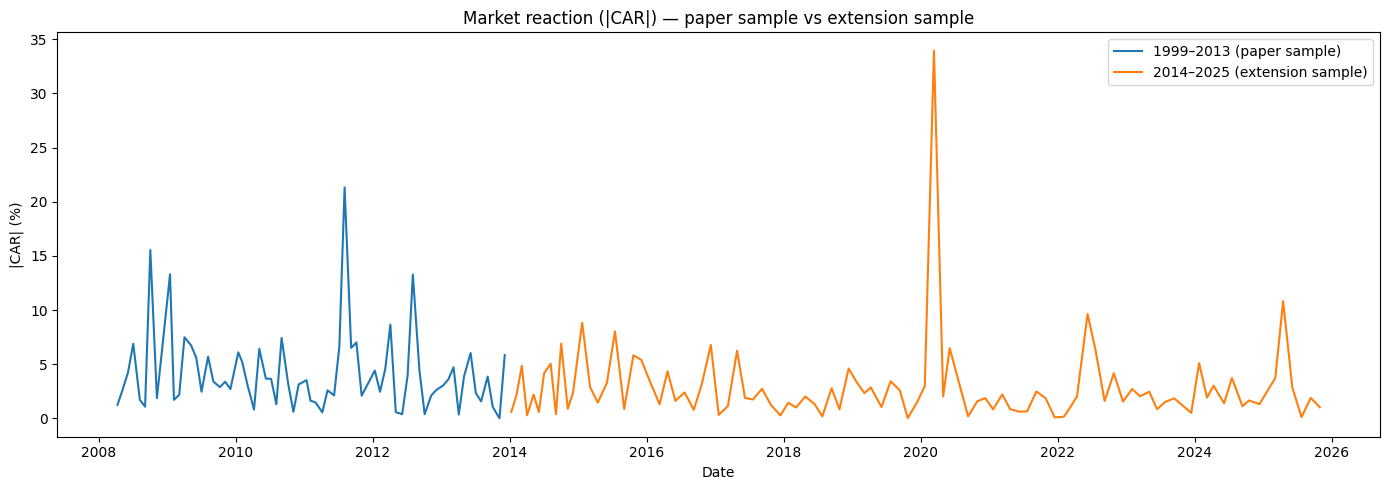

In [54]:
cutoff = pd.Timestamp("2014-01-01")
before = df_plot[df_plot["date"] <= cutoff]
after  = df_plot[df_plot["date"] > cutoff]

plt.figure(figsize=(14, 5))
plt.plot(before["date"], before["ABS_CAR"], label="1999–2013 (paper sample)")
plt.plot(after["date"],  after["ABS_CAR"],  label="2014–2025 (extension sample)")
plt.title("Market reaction (|CAR|) — paper sample vs extension sample")
plt.xlabel("Date")
plt.ylabel("|CAR| (%)")
plt.legend()
plt.tight_layout()
plt.show()

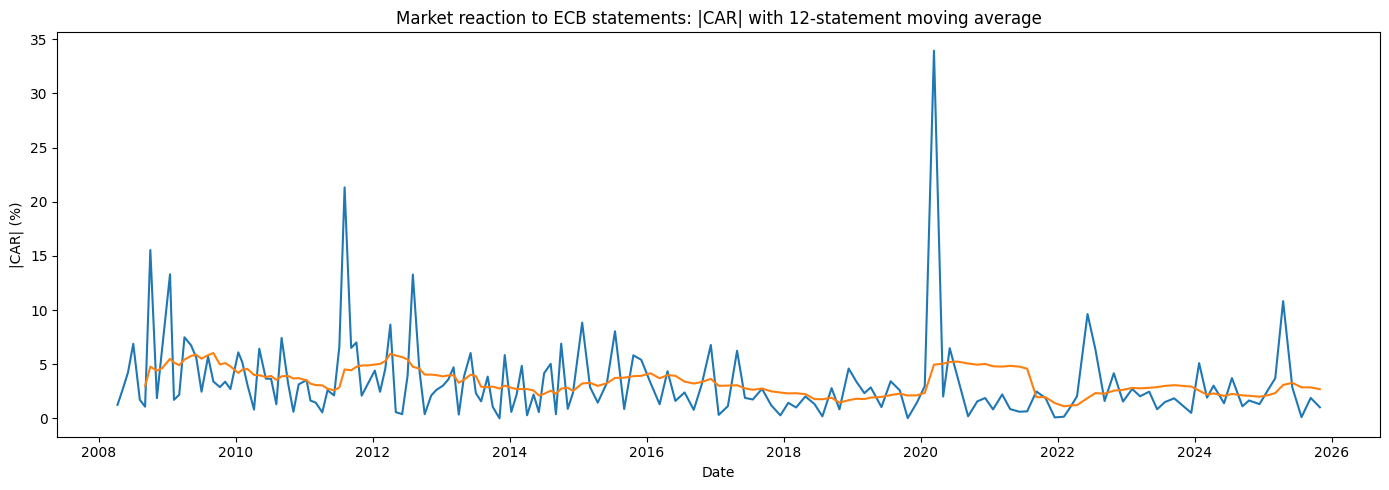

In [53]:
df_plot = df_plot.copy()
df_plot["ABS_CAR_MA12"] = df_plot["ABS_CAR"].rolling(window=12, min_periods=6).mean()

plt.figure(figsize=(14, 5))
plt.plot(df_plot["date"], df_plot["ABS_CAR"])
plt.plot(df_plot["date"], df_plot["ABS_CAR_MA12"])
plt.title("Market reaction to ECB statements: |CAR| with 12-statement moving average")
plt.xlabel("Date")
plt.ylabel("|CAR| (%)")
plt.tight_layout()
plt.show()